In [1]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")
include("../code/vectorfield_helper.jl")

using Dates
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
using JSON
using ProgressBars
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [2]:
function get_vf_for_parameters(params)
    rho, sigma, beta = params
    f(x, y, z) =    [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
    return f
end

get_vf_for_parameters (generic function with 1 method)

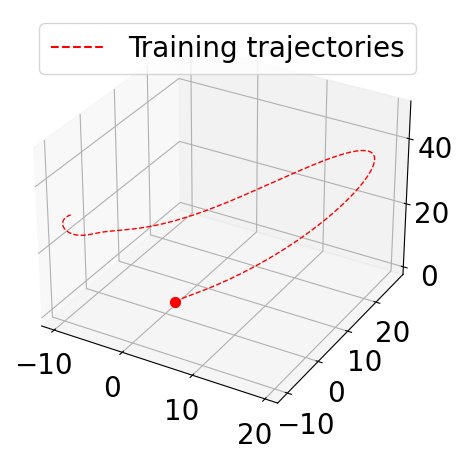

In [3]:
gr(size=(600,400))

ode_p = [28., 10., 8. / 3.]
ff = get_vf_for_parameters(ode_p)
Tf = 1.0 # T final
x0 =  [1.0, 1.0, 1.0]
box = ((-10, 10, .5), (-10, 10, .5), (-10, 10, .5))
sol = solve_ode(ff, x0, tspan=(0., Tf), length=4000, verbose=false)
PyPlot.plot3D(sol..., color=:red, ls="--", lw=1)
PyPlot.scatter3D(x0[1], x0[2], x0[3], color=:red, s=50)
PyPlot.plot([], [], [], color=:red, ls="--", label="Training trajectories")
PyPlot.legend();

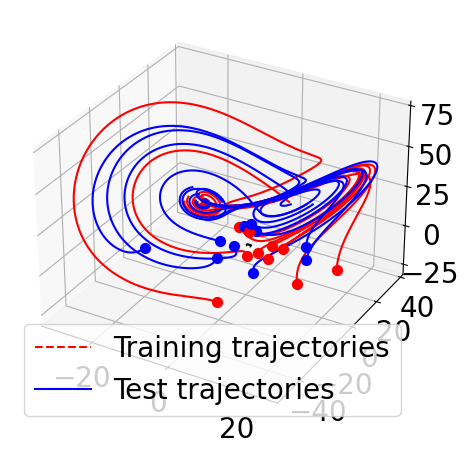

PyObject <matplotlib.legend.Legend object at 0x7f9bfde5fca0>

In [4]:
Random.seed!(0)
training_initial_conditions = [ 10 .* randn(3) for _ in 1:10 ]
test_initial_conditions = [10 .* randn(3) for _ in 1:10]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in training_initial_conditions[1:end]
    sol = solve_ode(ff, x0, length=1000, tspan = (0., Tf), verbose=false)
    PyPlot.plot3D(sol..., color=:red)
    PyPlot.scatter3D(x0..., color=:red, s=50)
end

for x0 in test_initial_conditions[1:end]
    sol = solve_ode(ff, x0, length=1000, tspan = (0., Tf), verbose=false)
    PyPlot.plot3D(sol..., color=:blue)
    PyPlot.scatter3D(x0..., color=:blue, s=50)
end

PyPlot.plot3D([], [], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot3D([], [], [], color=:blue, label="Test trajectories")
plot_box()
PyPlot.legend()


In [5]:
pos_x(model, p, x) = begin
    Set = @set x[2] - x[1] >=  0
    @constraint(model, p[1] >= 0, domain=Set) 
end


equilibrium_points(model, p, x) = begin
    for pi in p
        @constraint model pi(0, 0, 0) == 0
    end
end

equilibrium_points (generic function with 1 method)

In [6]:
r = train_and_test_model(2, .01, 1, 10, Dict(),training_initial_conditions,
                                test_initial_conditions, Tf, box; verbose=false)
r

Dict{String, Any} with 12 entries:
  "num_trajectories" => 1
  "training"         => 2.02756
  "num_samples"      => 10
  "deg"              => 2
  "training_x"       => [6.79107 17.266 … -8.89835 -9.91214; 8.28413 30.997 … -…
  "noise_level"      => 0.01
  "side_info"        => Any[]
  "training_xdot"    => [14.9374 137.308 … -13.9969 -1.40487; 205.847 78.9043 ……
  "learned_p"        => Polynomial{true, Float64}[-0.00728535x₁² + 0.00429873x₁…
  "box"              => 2.44803
  "obj_value"        => -0.0
  "test"             => 6.04923

In [9]:
side_info = [
    Dict(),
    Dict("equilibrium_points" => equilibrium_points),
    Dict("equilibrium_points" => equilibrium_points,
        "pos_X" => pos_x),
    
]
    
deg = (2, 3, 4, 5, 6)
noise_level = (0, 1e-3, 1e-2, 1e-1, )
num_trajectories = (1, 2, 3, 4)
num_samples = (10, 20, 40)

results = [train_and_test_model(args...,
                                training_initial_conditions,
                                test_initial_conditions, Tf, box; verbose=false)
                for args in tqdm(Iterators.product(deg, noise_level, num_trajectories, num_samples, side_info))];

0.0%┣                                             ┫ 0/720 [00:00<00:-36, -0s/it]
0.1%┣                                          ┫ 1/720 [00:01<Inf:Inf, InfGs/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
0.3%┣▏                                              ┫ 2/720 [00:02<18:40, 2s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
1.4%┣▋                                             ┫ 10/720 [00:06<07:56, 1it/s]
1.5%┣▊                                             ┫ 11/720 [00:07<07:47, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
1.7%┣▊                                             ┫

2.8%┣█▎                                            ┫ 20/720 [00:12<07:06, 2it/s]
2.9%┣█▍                                            ┫ 21/720 [00:12<07:09, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.9%┣█▉                                            ┫ 28/720 [00:17<07:04, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
6.9%┣███▏                                          ┫ 50/720 [00:31<07:07, 2it/s]
7.1%┣███▎                                          ┫ 51/720 [00:32<07:06, 2it/s]
7.2%┣███▎                                          ┫ 52/720 [00:33<07:06, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

8.9%┣████                                          ┫ 64/720 [00:41<07:09, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
9.0%┣████▏                                         ┫ 65/720 [00:42<07:15, 2it/s]
9.2%┣████▏                                         ┫ 66/720 [00:43<07:14, 2it/s]
9.3%┣████▎                                         ┫ 67/720 [00:44<07:13, 2it/s]
9.4%┣████▍           

11.0%┣█████                                        ┫ 79/720 [00:52<07:11, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
11.1%┣█████                                        ┫ 80/720 [00:54<07:15, 1it/s]
11.2%┣█████                                        ┫ 81/720 [00:54<07:14, 1it/s]
11.4%┣█████▏                                       ┫ 82/720 [00:55<07:12, 1it/s]
┌ Warning: Instabilit

12.9%┣█████▉                                       ┫ 93/720 [01:02<07:02, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
13.1%┣█████▉                                       ┫ 94/720 [01:03<07:02, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

14.7%┣██████▌                                     ┫ 106/720 [01:11<06:53, 1it/s]
14.9%┣██████▌                                     ┫ 107/720 [01:11<06:52, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
15.0%┣██████▋                                     ┫ 108/720 [01:12<06:51, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
16.4%┣███████▏                                    ┫ 118/720 [01:18<06:40, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

18.2%┣████████                                    ┫ 131/720 [01:27<06:33, 1it/s]
18.3%┣████████                                    ┫ 132/720 [01:27<06:33, 1it/s]
18.5%┣████████▏                                   ┫ 133/720 [01:28<06:32, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
20.1%┣████████▉                                   ┫ 145/720 [01:37<06:27, 1it/s]
20.3%┣█████████                                   ┫ 146/720 [01:38<06:26, 1it/s]
20.4%┣█████████                                   ┫ 147/720 [01:38<06:26, 1it/s]
20.6%┣█████████                                   ┫ 148/720 [01:39<06:25, 1it/s]
20.7%┣█████████                                   ┫ 149/720 [01:40<06:26, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.jul

23.1%┣██████████▏                                 ┫ 166/720 [01:52<06:18, 1it/s]
23.2%┣██████████▏                                 ┫ 167/720 [01:53<06:17, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
24.7%┣██████████▉                                 ┫ 178/720 [01:59<06:04, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

27.2%┣████████████                                ┫ 196/720 [02:11<05:52, 1it/s]
27.4%┣████████████                                ┫ 197/720 [02:12<05:51, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
27.5%┣████████████                                ┫ 198/720 [02:12<05:50, 1it/s]
27.6%┣████████████▏                               ┫ 199/720 [02:13<05:50, 1it/s]
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

34.6%┣███████████████▏                            ┫ 249/720 [02:59<05:39, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

36.0%┣███████████████▉                            ┫ 259/720 [03:04<05:29, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
37.2%┣████████████████▍                           ┫ 268/720 [03:10<05:21, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
40.0%┣█████████████████▋                          ┫ 288/720 [03:22<05:05, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
41.7%┣██████████████████▍                         ┫ 300/720 [03:31<04:57, 1it/s]
41.8%┣██████████████████▍                         ┫ 301/720 [03:32<04:56, 1it/s]
41.9%┣██████████████████▌                         ┫ 302/720 [03:33<04:55, 1it/s]
42.1%┣██████████████████▌                         ┫ 303/720 [03:33<04:55, 1it/s]
┌ Warning: Instabilit

43.6%┣███████████████████▏                        ┫ 314/720 [03:42<04:47, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
43.8%┣███████████████████▎                        ┫ 315/720 [03:43<04:48, 1it/s]
43.9%┣███████████████████▎                        ┫ 316/720 [03:44<04:47, 1it/s]
44.0%┣███████████████████▍                        ┫ 317/720 [03:44<04:46, 1it/s]
44.2%┣███████████████

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
46.2%┣████████████████████▍                       ┫ 333/720 [03:55<04:34, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
47.9%┣█████████████████████                       ┫ 345/720 [04:03<04:25, 1it/s]
48.1%┣█████████████████████▏                      ┫ 346/720 [04:04<04:24, 1it/s]
48.2%┣█████████████████████▏                      ┫ 347/720 [04:04<04:23, 1it/s]
48.3%┣█████████████████████▎                      ┫ 348/720 [04:05<04:23, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
49.7%┣█████████████████████▉                      ┫ 358/720 [04:12<04:15, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

53.6%┣███████████████████████▋                    ┫ 386/720 [04:31<03:55, 1it/s]
53.8%┣███████████████████████▋                    ┫ 387/720 [04:31<03:54, 1it/s]
53.9%┣███████████████████████▊                    ┫ 388/720 [04:32<03:53, 1it/s]
54.0%┣███████████████████████▊                    ┫ 389/720 [04:33<03:53, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

56.5%┣████████████████████████▉                   ┫ 407/720 [04:46<03:41, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
56.7%┣█████████████████████████                   ┫ 408/720 [04:47<03:40, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

60.8%┣██████████████████████████▊                 ┫ 438/720 [05:06<03:18, 1it/s]
61.0%┣██████████████████████████▉                 ┫ 439/720 [05:07<03:17, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
66.9%┣█████████████████████████████▌              ┫ 482/720 [05:59<02:58, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

70.3%┣███████████████████████████████             ┫ 506/720 [06:11<02:37, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
70.4%┣███████████████████████████████             ┫ 507/720 [06:12<02:37, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
71.4%┣███████████████████████████████▍            ┫ 514/720 [06:15<02:31, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
72.6%┣████████████████████████████████            ┫ 523/720 [06:21<02:24, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
73.6%┣████████████████████████████████▍           ┫ 530/720 [06:25<02:18, 1it/s]
73.8%┣████████████████████████████████▌           ┫ 531/720 [06:25<02:17, 1it/s]
73.9%┣████████████████████████████████▌           ┫ 532/720 [06:26<02:17, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

79.3%┣███████████████████████████████████         ┫ 571/720 [06:51<01:47, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

80.7%┣███████████████████████████████████▌        ┫ 581/720 [06:56<01:40, 1it/s]
80.8%┣███████████████████████████████████▋        ┫ 582/720 [06:57<01:39, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

81.8%┣████████████████████████████████████        ┫ 589/720 [07:00<01:34, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

86.5%┣██████████████████████████████████████      ┫ 623/720 [07:22<01:09, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

95.0%┣█████████████████████████████████████████▉  ┫ 684/720 [07:58<00:25, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
97.1%┣██████████████████████████████████████████▊ ┫ 699/720 [08:08<00:15, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

In [10]:
date_now = Dates.format(now(),"yyyy-mm-dd--HH-MM")
open("../data/lorenz-table/results-lorenz-$(date_now).json","w") do f 
    JSON.print(f, results, 4)
end